In [1]:
!nvidia-smi

Wed Nov 30 14:38:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import the packages
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib

import tensorflow as tf

In [3]:
print(tf.__version__)

2.6.4


## Building a data pipeline using `tf.data` for preparing the dataset with images and their corresponding masks

In [4]:
import tensorflow as tf

batch_size = 32
img_height = 256
img_width = 256
n_channels = 1

In [5]:
data_dir = '../input/covidqu/Infection Segmentation Data/Infection Segmentation Data/'

In [6]:
train_ds = tf.data.Dataset.list_files(
    data_dir + 'Train/*/images/*',
    shuffle=False
)

len(train_ds)

2022-11-30 14:38:59.808977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 14:38:59.901834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 14:38:59.902627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 14:38:59.904810: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

3728

In [7]:
test_ds = tf.data.Dataset.list_files(
    data_dir + 'Test/*/images/*',
    shuffle=False
)

len(test_ds)

1166

In [8]:
val_ds = tf.data.Dataset.list_files(
    data_dir + 'Val/*/images/*',
    shuffle=False
)

len(val_ds)

932

In [9]:
for f in train_ds.take(4):
    print(f)

tf.Tensor(b'../input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_1.png', shape=(), dtype=string)
tf.Tensor(b'../input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_100.png', shape=(), dtype=string)
tf.Tensor(b'../input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_1000.png', shape=(), dtype=string)
tf.Tensor(b'../input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_1001.png', shape=(), dtype=string)


In [10]:
# filter out the Non-COVID images from the datasets
import os

def filter_non_covid_images(file_path):
  return tf.strings.split(file_path, os.path.sep)[-3] != 'Non-COVID'

train_ds_filtered = train_ds.filter(filter_non_covid_images)
test_ds_filtered = test_ds.filter(filter_non_covid_images)
val_ds_filtered = val_ds.filter(filter_non_covid_images)

In [11]:
# process the images and get their corresponding infection masks

def process_image(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
   
  image = tf.io.read_file(file_path)
  image = tf.image.decode_png(image, channels=n_channels) 
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [img_height, img_width])

  mask_path = tf.strings.join([data_dir, parts[-4], parts[-3], 'infection masks', parts[-1]], os.path.sep)

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=n_channels)
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  mask = tf.image.resize(mask, [img_height, img_width])

  return image, mask

In [12]:
train_ds_labelled = train_ds_filtered.map(process_image)
test_ds_labelled = test_ds_filtered.map(process_image)
val_ds_labelled = val_ds_filtered.map(process_image)

In [13]:
train_ds_shuffled = train_ds_labelled.shuffle(4000)
test_ds_shuffled = test_ds_labelled.shuffle(4000)
val_ds_shuffled = val_ds_labelled.shuffle(4000)

2022-11-30 14:39:52.158590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called..

tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


<Figure size 432x288 with 0 Axes>

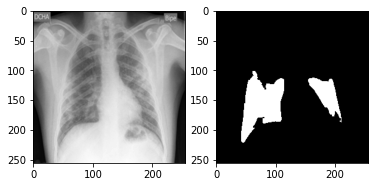

<Figure size 432x288 with 0 Axes>

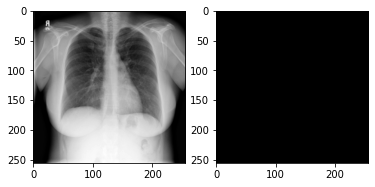

<Figure size 432x288 with 0 Axes>

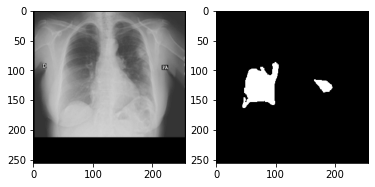

<Figure size 432x288 with 0 Axes>

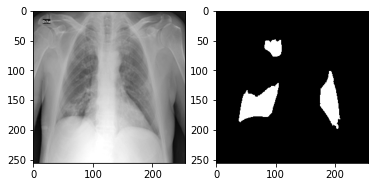

In [14]:
for image, mask in train_ds_shuffled.take(4):
  plt.figure()
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(image[:,:,0], cmap='gray')
  ax[1].imshow(mask[:,:,0], cmap='gray')
  print(mask[:3,:3,0])

In [15]:
# batch the dataset
train_ds = train_ds_shuffled.batch(batch_size)
test_ds = test_ds_shuffled.batch(batch_size)
val_ds = val_ds_shuffled.batch(batch_size)

In [16]:
# configure the dataset for performance so that disk reads doesn't become a bottleneck
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the segmentation model

For the segmentation model, `UNet` architecture will be implemented. UNet is an image segmentation model which consists of an encoder and a decoder with skip connections between them.

## UNet Architecture

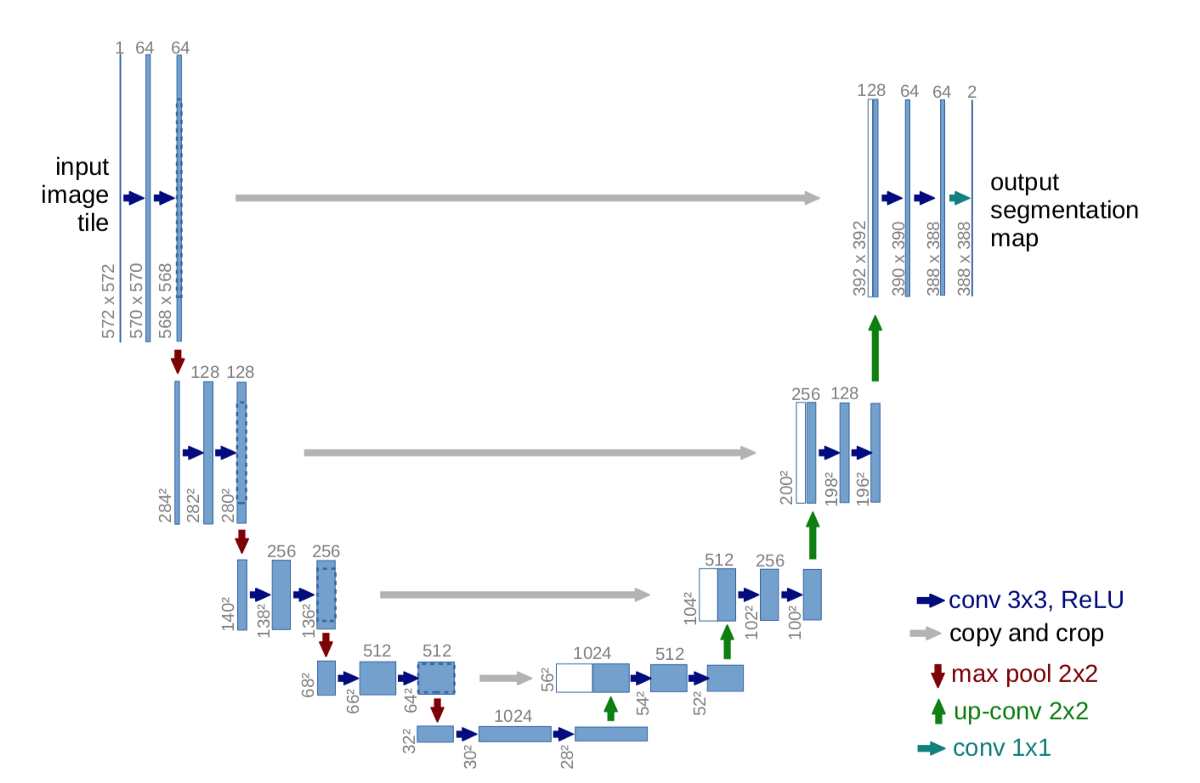

## Implementing the Encoder

In [17]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    Concatenate
)

from tensorflow.keras import Model

In [18]:
# input layer
encoder_input = Input(shape = (img_height, img_width, n_channels))

# 1st downsample block
conv_1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(encoder_input)
conv_2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
pool_1 = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(conv_2)
drop_1 = Dropout(0.3)(pool_1)

# 2nd downsample block
conv_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_1)
conv_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_3)
pool_2 = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(conv_4)
drop_2 = Dropout(0.3)(pool_2)

# 3rd downsample block
conv_5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_2)
conv_6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_5)
pool_3 = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(conv_6)
drop_3 = Dropout(0.3)(pool_3)

# 4th downsample block
conv_7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_3)
conv_8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_7)
pool_4 = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(conv_8)
drop_4 = Dropout(0.3)(pool_4)

# middle block
conv_9 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_4)
encoder_output = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_9)

Encoder = Model(inputs=encoder_input, outputs=encoder_output)

In [19]:
Encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928 

In [20]:
# getting the layers required for skip connections
skip_1 = conv_2
skip_2 = conv_4
skip_3 = conv_6
skip_4 = conv_8

## Implementing the Decoder

In [21]:
# 1st upsample block, gets the input from the encoder
conv_1 = Conv2DTranspose(256, 2, strides=(2,2), padding='same')(encoder_output)
concat_1 = Concatenate(axis=3)([conv_1, skip_4])
drop_1 = Dropout(0.3)(concat_1)
conv_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_1)
conv_3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_2)

# 2nd upsample block
conv_4 = Conv2DTranspose(128, 2, strides=(2,2), padding='same')(conv_3)
concat_2 = Concatenate(axis=3)([conv_4, skip_3])
drop_2 = Dropout(0.3)(concat_2)
conv_5 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_2)
conv_6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_5)

# 3rd upsample block
conv_7 = Conv2DTranspose(64, 2, strides=(2,2), padding='same')(conv_6)
concat_3 = Concatenate(axis=3)([conv_7, skip_2])
drop_3 = Dropout(0.3)(concat_3)
conv_8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_3)
conv_9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_8)

# 4th upsample block
conv_10 = Conv2DTranspose(32, 2, strides=(2,2), padding='same')(conv_9)
concat_4 = Concatenate(axis=3)([conv_10, skip_1])
drop_4 = Dropout(0.3)(concat_4)
conv_11 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop_4)
conv_12 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_11)

# output layer
decoder_output = Conv2D(1, 1, activation='sigmoid')(conv_12)

## Combining the Encoder and Decoder to create UNet

In [22]:
# the final UNet model
UNet = Model(inputs=encoder_input, outputs=decoder_output, name='UNet')

In [23]:
UNet.summary()

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

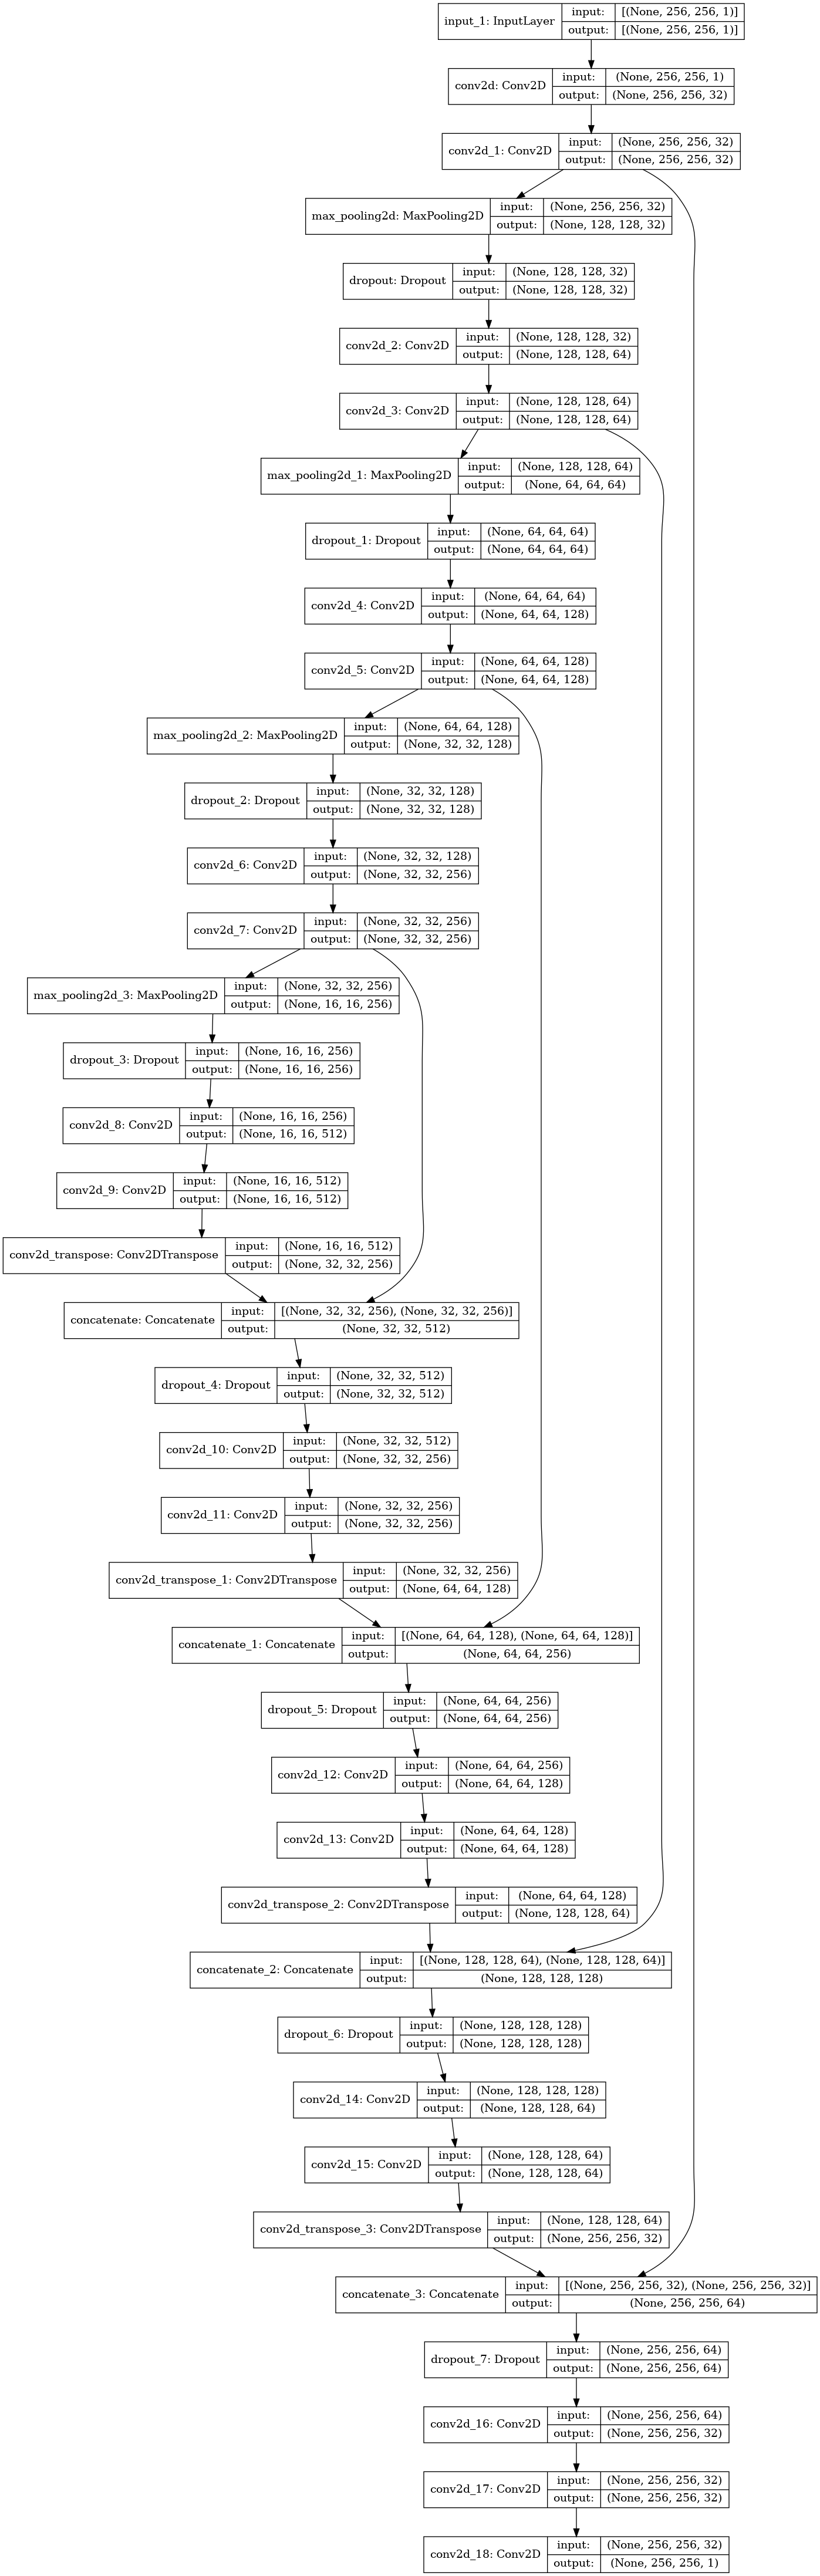

In [24]:
tf.keras.utils.plot_model(UNet, show_shapes=True)

## Training the model

In [25]:
# function for model checkpointing
import os

def create_model_checkpoint(model_name, save_path="model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_path, f"{model_name}.h5"),
    verbose=0,
    save_best_only=True
  )

In [26]:
# compile the model
UNet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fit the model on the training dataset
history = UNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[create_model_checkpoint(model_name=UNet.name, save_path='model_checkpoints')]
)

Epoch 1/30


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

     88/Unknown - 45s 310ms/step - loss: 0.3035 - accuracy: 0.9026

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

88/88 [==============================] - 57s 442ms/step - loss: 0.3035 - accuracy: 0.9026 - val_loss: 0.2545 - val_accuracy: 0.9076
Epoch 2/30
88/88 [==============================] - 27s 306ms/step - loss: 0.2562 - accuracy: 0.9070 - val_loss: 0.2385 - val_accuracy: 0.9076
Epoch 3/30
88/88 [==============================] - 27s 306ms/step - loss: 0.2412 - accuracy: 0.9067 - val_loss: 0.2189 - val_accuracy: 0.9080
Epoch 4/30
88/88 [==============================] - 27s 306ms/step - loss: 0.2081 - accuracy: 0.9103 - val_loss: 0.1943 - val_accuracy: 0.9148
Epoch 5/30
88/88 [==============================] - 27s 307ms/step - loss: 0.1798 - accuracy: 0.9219 - val_loss: 0.1636 - val_accuracy: 0.9278
Epoch 6/30
88/88 [==============================] - 27s 306ms/step - loss: 0.1597 - accuracy: 0.9301 - val_loss: 0.1483 - val_accuracy: 0.9360
Epoch 7/30
88/88 [==============================] - 27s 306ms/step - loss: 0.1457 - accuracy: 0.9363 - val_loss: 0.1367 - val_accuracy: 0.9417
Epoch 8/30

In [27]:
UNet.evaluate(test_ds)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

28/28 [==============================] - 13s 114ms/step - loss: 0.1069 - accuracy: 0.9611


[0.10692831873893738, 0.9611034989356995]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

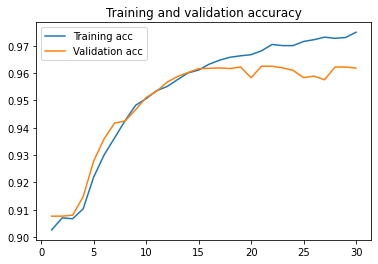

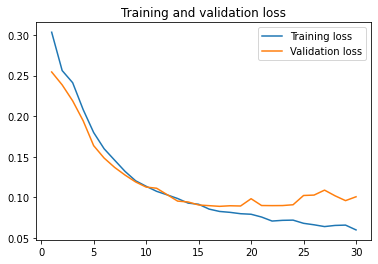

In [29]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Making predictions with the model

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

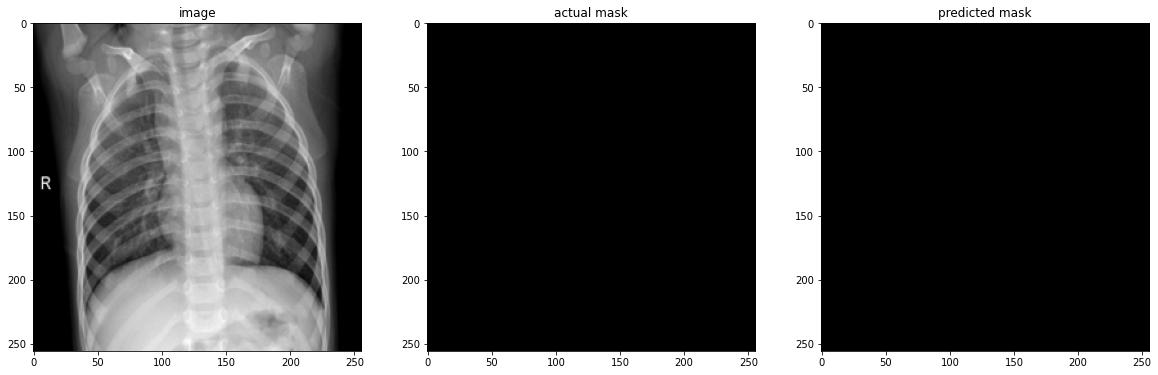

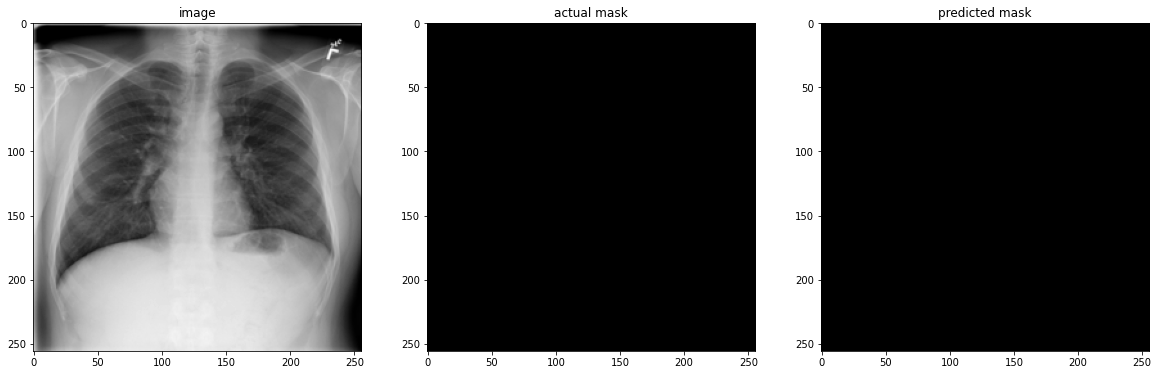

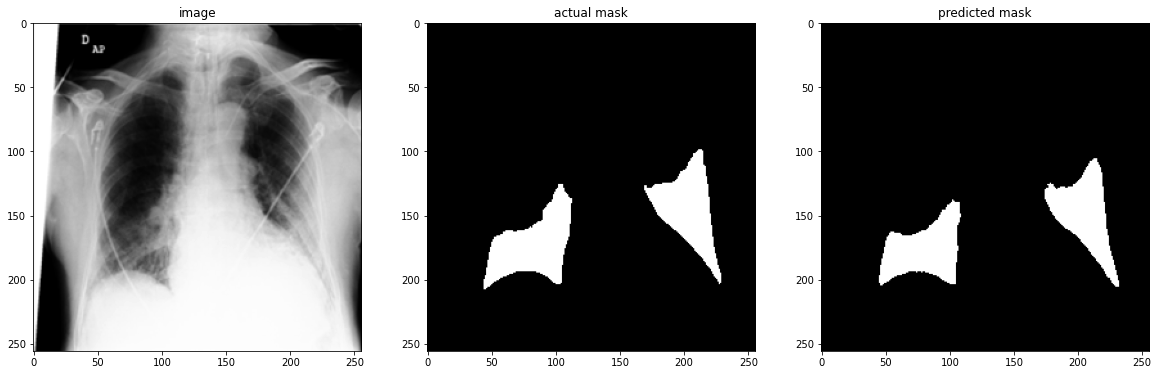

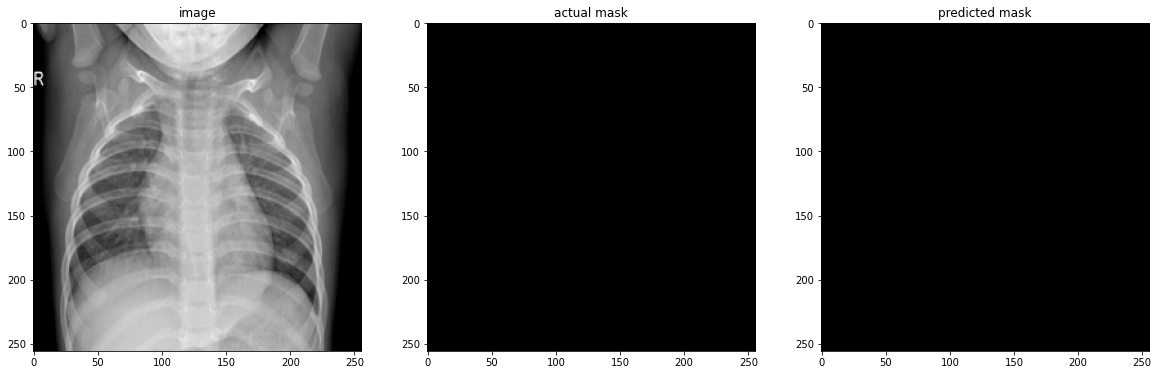

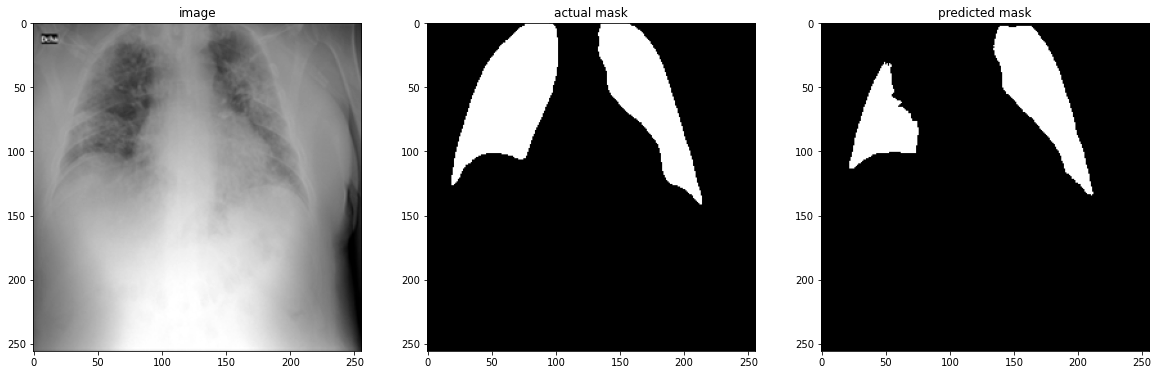

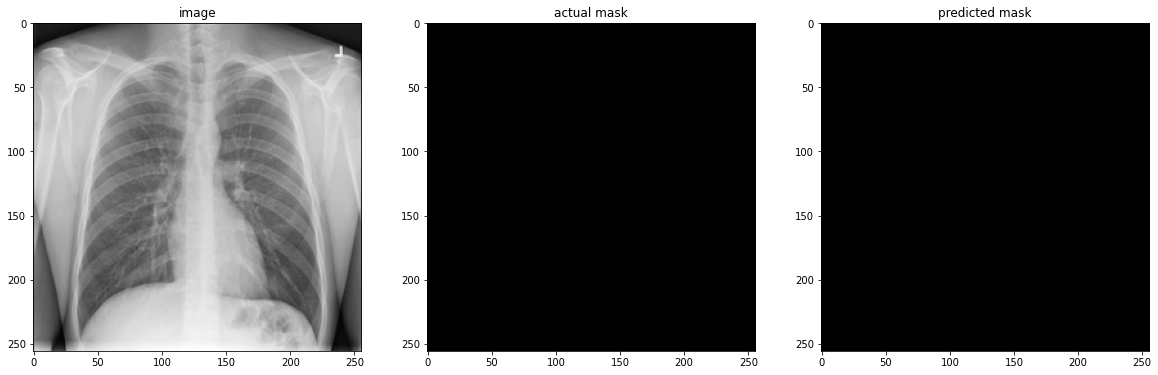

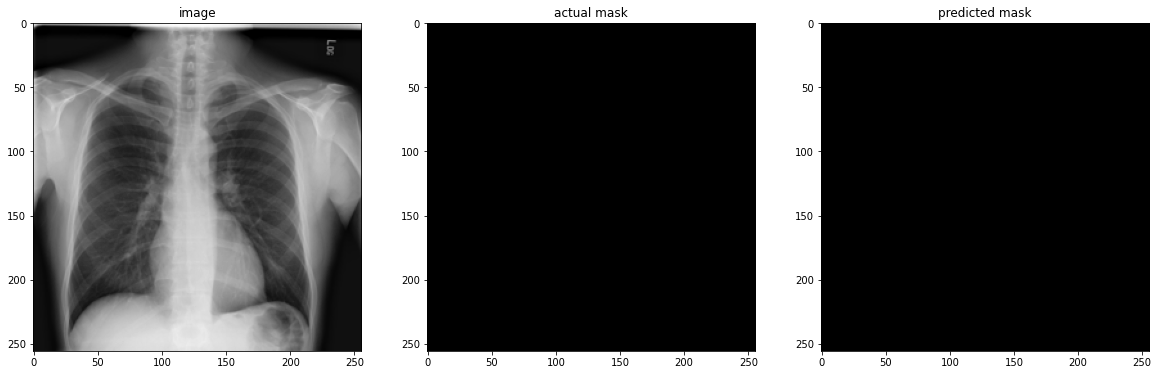

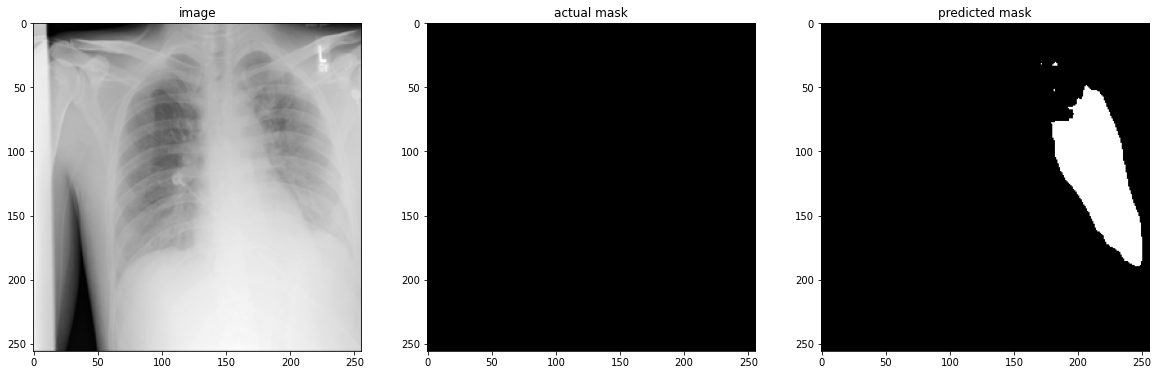

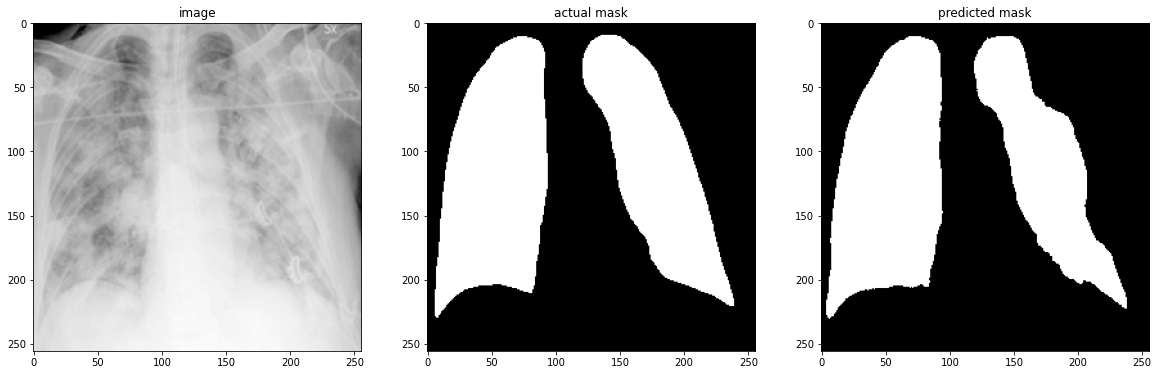

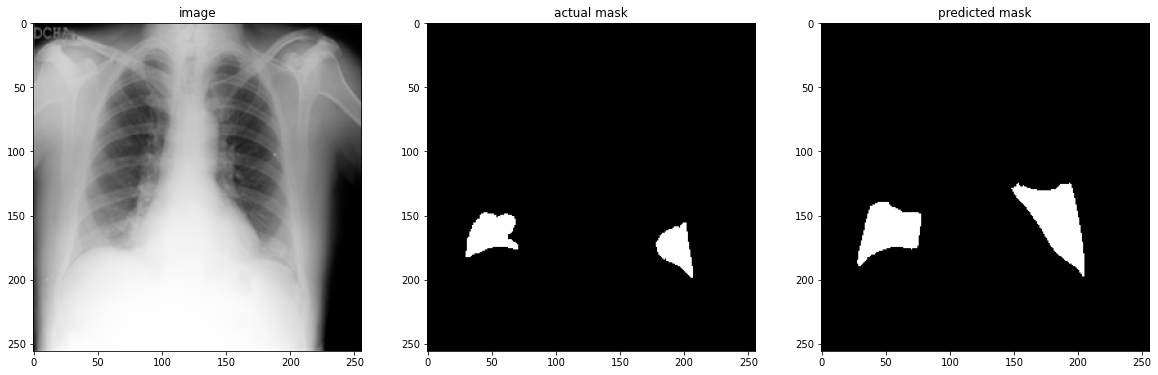

In [31]:
for image, mask in test_ds_shuffled.take(10):
    fig, ax = plt.subplots(1, 3, figsize=(20,14))
    
    # find the mask predicted by the model
    pred_mask = UNet.predict(tf.expand_dims(image, axis=0))[0]
    pred_mask[pred_mask>0.5] = 1.0
    pred_mask[pred_mask<0.5] = 0.0
    
    ax[0].set_title("image")
    ax[0].imshow(image[:,:,0], cmap='gray')
    
    ax[1].set_title("actual mask")
    ax[1].imshow(mask[:,:,0], cmap='gray')
    
    ax[2].set_title("predicted mask")
    ax[2].imshow(pred_mask[:,:,0], cmap='gray')